In [136]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load and preprocess the Quebec energy dataset
data = pd.read_csv(r'data\processed\yukon_energy.csv')
data['date'] = pd.to_datetime(data['date'])

# Ensure all generation types are consistent across dates
df_grouped = data.groupby(['date', 'generation_type'], as_index=False)['megawatt_hours'].sum()
unique_generation_types = df_grouped['generation_type'].unique()

def standardize_generation_types(df, unique_types):
    all_months = df['date'].unique()
    standardized_rows = [
        {'date': month, 'generation_type': g_type, 'megawatt_hours': 0}
        for month in all_months
        for g_type in unique_types
        if g_type not in df[df['date'] == month]['generation_type'].values
    ]
    return pd.concat([df, pd.DataFrame(standardized_rows)], ignore_index=True)

df_standardized = standardize_generation_types(df_grouped, unique_generation_types)
df_pivot = df_standardized.pivot(index='date', columns='generation_type', values='megawatt_hours').fillna(0)

# Normalize data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df_pivot)


In [137]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_tcn(input_shape, output_shape):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv1D(128, kernel_size=3, padding='causal', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.SpatialDropout1D(0.2)(x)

    for _ in range(8):  # Add additional layers for complexity
        x = layers.Conv1D(256, kernel_size=5, padding='causal', activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.SpatialDropout1D(0.3)(x)

    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(output_shape, activation='linear')(x)
    return models.Model(inputs, outputs)


In [138]:
# Prepare sequences
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i + n_steps])
        y.append(data[i + n_steps])
    return np.array(X), np.array(y)

n_steps = 60
X, y = create_sequences(data_scaled, n_steps)
X_train, y_train = X, y  # Use all data for training

# Build and train the model
model = build_tcn((n_steps, X_train.shape[2]), y_train.shape[1])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=2)

# Forecasting
forecast_horizon = pd.date_range(df_pivot.index[-1] + pd.DateOffset(months=1), '2030-12-01', freq='MS')
forecast_input = data_scaled[-n_steps:].reshape(1, n_steps, X_train.shape[2])
forecast = []

for _ in range(len(forecast_horizon)):
    prediction = model.predict(forecast_input)
    forecast.append(prediction[0])
    forecast_input = np.append(forecast_input[:, 1:, :], prediction.reshape(1, 1, -1), axis=1)

forecast_rescaled = scaler.inverse_transform(forecast)
forecast_df = pd.DataFrame(forecast_rescaled, index=forecast_horizon, columns=df_pivot.columns)


Epoch 1/50
4/4 - 6s - loss: 0.1617 - mae: 0.3126 - 6s/epoch - 2s/step
Epoch 2/50
4/4 - 1s - loss: 0.2000 - mae: 0.3393 - 997ms/epoch - 249ms/step
Epoch 3/50
4/4 - 1s - loss: 0.1470 - mae: 0.2968 - 971ms/epoch - 243ms/step
Epoch 4/50
4/4 - 1s - loss: 0.1566 - mae: 0.3127 - 938ms/epoch - 235ms/step
Epoch 5/50
4/4 - 1s - loss: 0.1405 - mae: 0.2898 - 908ms/epoch - 227ms/step
Epoch 6/50
4/4 - 1s - loss: 0.1262 - mae: 0.2750 - 1s/epoch - 254ms/step
Epoch 7/50
4/4 - 1s - loss: 0.1355 - mae: 0.2851 - 1s/epoch - 263ms/step
Epoch 8/50
4/4 - 1s - loss: 0.1032 - mae: 0.2477 - 1s/epoch - 257ms/step
Epoch 9/50
4/4 - 1s - loss: 0.0916 - mae: 0.2347 - 1s/epoch - 256ms/step
Epoch 10/50
4/4 - 1s - loss: 0.1003 - mae: 0.2512 - 1s/epoch - 290ms/step
Epoch 11/50
4/4 - 1s - loss: 0.1023 - mae: 0.2505 - 1s/epoch - 306ms/step
Epoch 12/50
4/4 - 1s - loss: 0.0729 - mae: 0.2104 - 1s/epoch - 327ms/step
Epoch 13/50
4/4 - 1s - loss: 0.0755 - mae: 0.2148 - 1s/epoch - 305ms/step
Epoch 14/50
4/4 - 1s - loss: 0.0705 - 

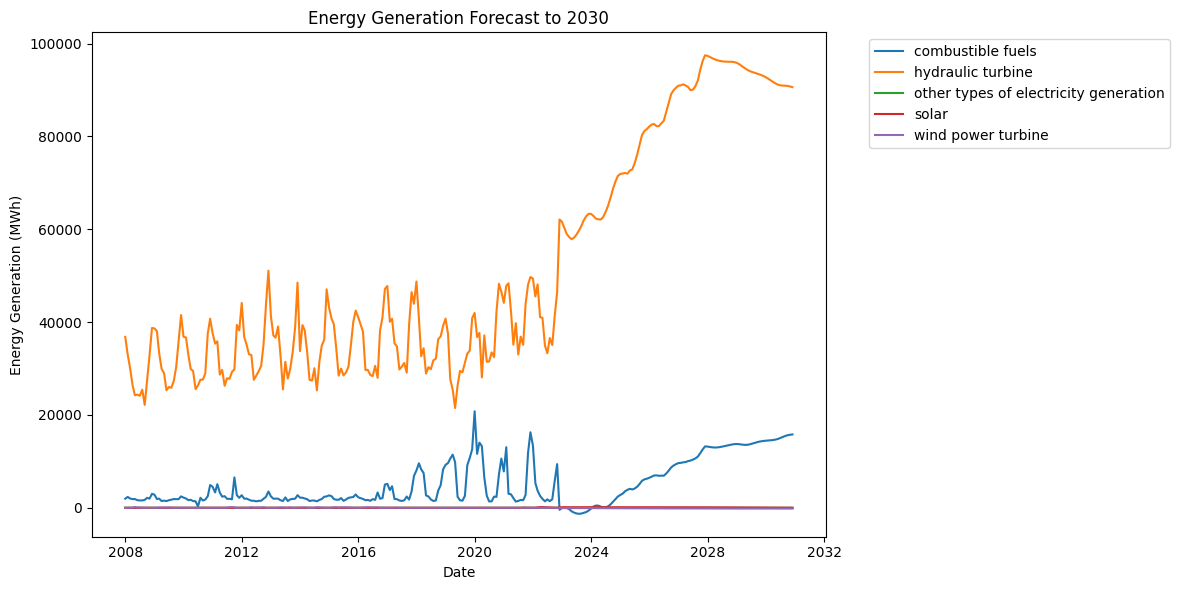

In [139]:
# Combine historical and forecasted data
combined = pd.concat([df_pivot, forecast_df])

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
for column in df_pivot.columns:
    plt.plot(combined.index, combined[column], label=column)
plt.title("Energy Generation Forecast to 2030")
plt.xlabel("Date")
plt.ylabel("Energy Generation (MWh)")
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()


In [140]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_lstm(input_shape, output_shape):
    inputs = layers.Input(shape=input_shape)

    # Block 1: First LSTM layer
    x = layers.LSTM(128, return_sequences=True, activation='tanh')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    # Block 2: Second LSTM layer
    x = layers.LSTM(256, return_sequences=True, activation='tanh')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    # Block 3: Third LSTM layer
    x = layers.LSTM(128, return_sequences=False, activation='tanh')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    # Dense output layer
    outputs = layers.Dense(output_shape, activation='linear')(x)

    # Define the model
    model = models.Model(inputs, outputs)
    return model


In [141]:
# Build and compile the LSTM model
input_shape = (n_steps, X_train.shape[2])  # (time_steps, features)
output_shape = y_train.shape[1]  # Number of target features

lstm_model = build_lstm(input_shape, output_shape)

# Compile the model
lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = lstm_model.fit(
    X_train, y_train,
    epochs=50,  # Adjust epochs based on dataset size
    batch_size=32,  # Experiment with batch sizes
    verbose=2
)


Epoch 1/50
4/4 - 10s - loss: 2.2529 - mae: 1.1635 - 10s/epoch - 3s/step
Epoch 2/50
4/4 - 1s - loss: 1.4587 - mae: 0.9627 - 1s/epoch - 312ms/step
Epoch 3/50
4/4 - 1s - loss: 1.2685 - mae: 0.8998 - 1s/epoch - 306ms/step
Epoch 4/50
4/4 - 1s - loss: 1.0576 - mae: 0.8356 - 1s/epoch - 338ms/step
Epoch 5/50
4/4 - 1s - loss: 0.9566 - mae: 0.7673 - 1s/epoch - 344ms/step
Epoch 6/50
4/4 - 1s - loss: 0.9441 - mae: 0.7704 - 1s/epoch - 375ms/step
Epoch 7/50
4/4 - 1s - loss: 0.9098 - mae: 0.7674 - 941ms/epoch - 235ms/step
Epoch 8/50
4/4 - 1s - loss: 0.7651 - mae: 0.7051 - 1s/epoch - 361ms/step
Epoch 9/50
4/4 - 2s - loss: 0.8453 - mae: 0.7188 - 2s/epoch - 380ms/step
Epoch 10/50
4/4 - 1s - loss: 0.8294 - mae: 0.7068 - 1s/epoch - 369ms/step
Epoch 11/50
4/4 - 1s - loss: 0.8012 - mae: 0.7213 - 1s/epoch - 321ms/step
Epoch 12/50
4/4 - 1s - loss: 0.7394 - mae: 0.6806 - 1s/epoch - 281ms/step
Epoch 13/50
4/4 - 1s - loss: 0.8306 - mae: 0.7179 - 1s/epoch - 325ms/step
Epoch 14/50
4/4 - 1s - loss: 0.8240 - mae: 0.

In [142]:
import datetime

# Define the forecasting horizon (from the last date in the dataset to 2030-12-31)
last_date = df_pivot.index[-1]
forecast_horizon = pd.date_range(last_date + pd.DateOffset(months=1), '2030-12-01', freq='MS')

# Start with the last n_steps of the dataset
forecast_input = data_scaled[-n_steps:].reshape(1, n_steps, X_train.shape[2])

# Placeholder for predictions
forecast = []

# Iteratively predict the future
for _ in range(len(forecast_horizon)):
    prediction = lstm_model.predict(forecast_input)
    forecast.append(prediction[0])
    forecast_input = np.append(forecast_input[:, 1:, :], prediction.reshape(1, 1, -1), axis=1)

# Rescale predictions back to original values
forecast_rescaled = scaler.inverse_transform(forecast)

# Create a DataFrame for the forecast
forecast_df = pd.DataFrame(forecast_rescaled, index=forecast_horizon, columns=df_pivot.columns)

# Display the forecast
print(forecast_df.head())


1/1 [==============================] - 0s 45ms/step
generation_type  combustible fuels  hydraulic turbine  \
2022-12-01             4630.716238       40528.657936   
2023-01-01             4683.547115       40382.998280   
2023-02-01             4736.049753       40303.082555   
2023-03-01             4780.111089       40299.409039   
2023-04-01             4812.972265       40367.086770   

generation_type  other types of electricity generation     solar  \
2022-12-01                                   -0.045988  6.290503   
2023-01-01                                   -0.048668  6.071301   
2023-02-01                                   -0.051893  6.086767   
2023-03-01                                   -0.055527  6.351731   
2023-04-01                                   -0.059225  6.807342   

generation_type  wind power turbine  
2022-12-01               -62.701551  
2023-01-01               -63.033689  
2023-02-01               -63.019628  
2023-03-01               -62.698343  
2023-0

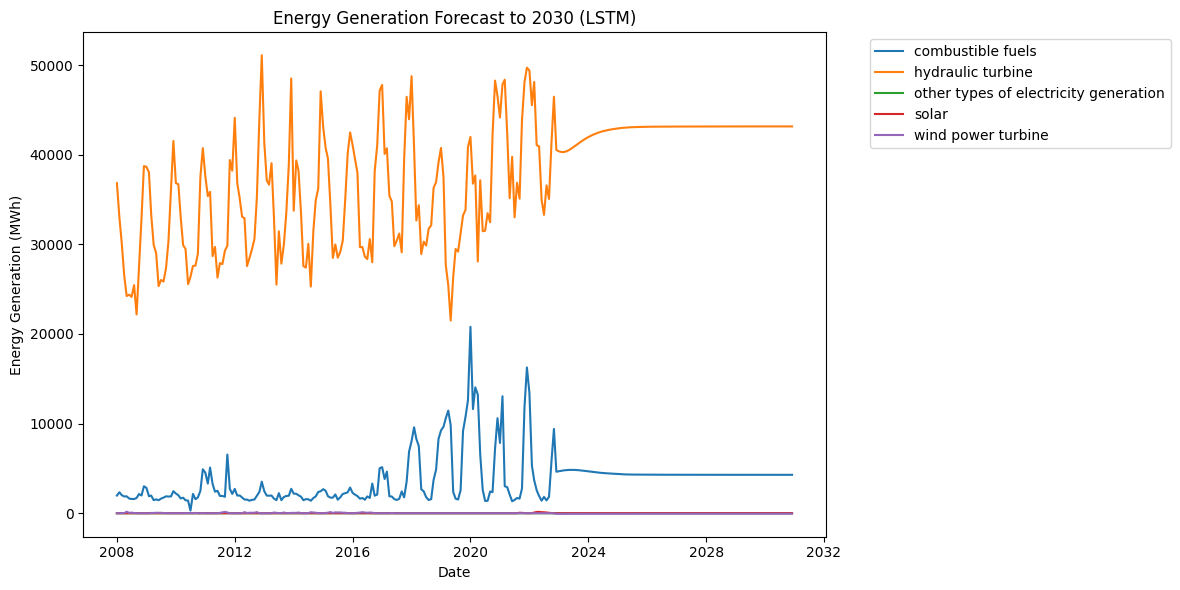

In [143]:
import matplotlib.pyplot as plt

# Combine historical data with forecasted data
combined = pd.concat([df_pivot, forecast_df])

# Plot each generation type
plt.figure(figsize=(12, 6))
for column in df_pivot.columns:
    plt.plot(combined.index, combined[column], label=column)

plt.title("Energy Generation Forecast to 2030 (LSTM)")
plt.xlabel("Date")
plt.ylabel("Energy Generation (MWh)")
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()
